# TMDB Rating Prediction Based on Several Factors (Emanuel Azcona)

Is it possible to predict a movie's critic success before it is even released? Are there key/certain cast members (actors/actresses) or essential crew (directors, producers, etc.) that contribute to the critical success of a movie? In this project we investigate and create a an appropiate regression model for predicting a movie's IMDB critic rating based on different attributes like: cast, crew, and more.

In this project, critic rating is given to us in the form of a non-integer score between $0$ and $10$.

## Dataset (TMDB)

The dataset was obtained from Kaggle under: https://www.kaggle.com/tmdb/tmdb-movie-metadata. Per a DMCA takedown request from IMDB, the original IMDB dataset was removed. In order to minimize the impact, Kaggle replaced the dataset with the TMDB dataset, which consists of a similar set of films and data fields in accordance with their terms of use (https://www.themoviedb.org/documentation/api/terms-of-use).

The dataset itself contains two .$\texttt{CSV}$ files:
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{credits.csv}$
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{movies.csv}$

where the "credits" file contains crediting information about the 5000 movies in the datset (title, cast, crew) and the "movies" file contains the following information about each movie:
- budget
- voter rating
- voter count (number of people who voted)
- revenue
- genre(s)
- homepage
- keywords
- original language
- original title
- and way more.

For the purposes of this experiment, we're only going to focus on using the entire "credits" file and the budget/revenue columns of the "movies" file.

### Loading Credits & Movies Files

For data manipulation throughout this experiment, we're going to rely on the Pandas library (available through $\texttt{pip}$ or $\texttt{conda}$).

In [1]:
import pandas as pd # typical naming convention for abbreviating [pandas]
import numpy as np  # using the original NumPy library, not the autograd one (since I'm using Keras)

import ast          # I only use this library to convert strings into their literal Python interpretations

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold    # Sci-kit learn functions for dividing data into testing/training sets using indices

import keras
from keras.models import Sequential          # Very simple sequential layer model making in Keras
from keras.layers import Dense               # Simple fully-connected feed-forward layers in Keras
from keras.layers import Input, add
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
# load in dataset using pandas
creditsDF = pd.read_csv('tmdb_5000_credits.csv')
moviesDF = pd.read_csv('tmdb_5000_movies.csv')

# sanity check (compare number of samples in each .CSV file)
print('There are ' + str( creditsDF.shape[0] ) + ' movies in the "credits" file.')
print('There are ' + str( moviesDF.shape[0] ) + ' movies in the "movies" file.')

There are 4803 movies in the "credits" file.
There are 4803 movies in the "movies" file.


In [3]:
# I wrote this as a sanity-check to see if every row in each .CSV file corresponds
# to the respective row in the other.
mistakeInData = False
for i in range( creditsDF.shape[0] ):
    if creditsDF['movie_id'][i] != moviesDF['id'][i]:
        mistakeInData = True
if mistakeInData:
    print('\nSomething is up dude. Double-check the data.')
else:
    print('\nDataset is legitimate. Proceed.')
    
# Overview of the first few samples for the movies dataframe
moviesDF.head()


Dataset is legitimate. Proceed.


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
# Overview of the first few samples for the credits dataframe
creditsDF.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Cleaning and Manipulating Data to Create Clean Dictionaries of Movie Information

It's a little annoying to be manipulating two seperate dataframes related to one set of data. For that reason, a single dictionary is created to avoid confusion across datasets. The dictionary data structure was chosen because of its constant, $O(1)$, indexing runtime (I read some forums and documentation warning that Pandas indexing may not run, $O(1)$).

In the process of creating the dictionary, we must be careful to only extract and store information that is relevant and/or may be helpful to determining critic rating. One example of information that may not be helpful that is not included is the homepage to a particular movie.

Throughout the function below, I detail which features I decide to store during each iteration while parsing through the movie dataset.

I also made the decision to remove any movie in the dataset that has less voter counts than the overall median voter count. Why did I decide upon this median metric? I can not give a reasonable answer to that other than, it seemed reasonable. The motivation behind this is credited to some of the movies having unreasonably high ($10$) or low ($0$) ratings with only $1$ or $0$ voters.

In [5]:
def createMovieDictionary(creditsDF, moviesDF):
    
    # initialize dictionary of movies
    movies = {}
    
    # initiailize corresponding set of keys for the movies dictionary
    # I use a set to make sure that no movie has duplicate keys
    keys = set()
    
    # go through every movie in the dataset O(N)
    for i in range(moviesDF.shape[0]):
        
        budget = moviesDF['budget'][i]          # temporarily store the budget for the current movie
        allVoteCounts = moviesDF['vote_count']  # temporarily store vote count for current movie
        medVoteCount = np.median(allVoteCounts) # determine median of the vote counts
        
        # check to see if we're dealing with a non-zero budget movie
        if budget > 0:
            
            # only continue if the current number of votes is bigger than the median
            if allVoteCounts[i] >= medVoteCount:
                
                cast = ast.literal_eval( creditsDF['cast'][i] ) # temporarily extract cast and create a list
                cast = set( [member['name'] for member in cast if member['order'] <= 2] )

                crew = ast.literal_eval( creditsDF['crew'][i] ) # repeat the cast process for the crew members as well
                crew = set( [member['name'] for member in crew if member['job'] == 'Director' or member['job'] == 'Producer'] )
                
                genres = ast.literal_eval( moviesDF['genres'][i] ) # repeat for genres
                genres = set( [g['name'] for g in genres] )
                
                production_companies = ast.literal_eval( moviesDF['production_companies'][i] ) # repeat for production companies
                production_companies = set( [p['name'] for p in production_companies] )
                
                
                # temporarily save movie ID of the movie from id column of current film
                movID = moviesDF['id'][i]

                # temporarily save title of current movie
                title = moviesDF['title'][i]
                
                # temporarily save the rating of the current movie
                rating = moviesDF['vote_average'][i]
                
                # append the set of keys with the current movie's ID
                keys.update({movID})
                
                movies[movID] = {'title': title}              # first entry of the current dictionary is the title
                movies[movID]['cast'] = cast                  # assign set of cast members
                movies[movID]['crew'] = crew                  # assign set of crew members
                movies[movID]['budget'] = budget              # assign budget
                movies[movID]['rate'] = rating                # assign rating
                movies[movID]['genres'] = genres              # assign genres
                movies[movID]['prod'] = production_companies  # assign production companies

    return movies, keys

In [6]:
movies, keys = createMovieDictionary(creditsDF,moviesDF)

# I'm paranoid, so I'm just deleting these dataframes now to free up some space
del moviesDF, creditsDF

# Another sanity check
print("The movie dictionary has: " + str(len(movies)) + " entries." )

The movie dictionary has: 2302 entries.


### Determine Distinct Items Pertaining to Features That Are Sets/Lists

Next, a function was created to create individual sets of the distinct cast, crew, genres, and production companies in the movies we extracted. We can utilize the Python $\texttt{set}(\cdot)$ method that creates a distinct set data structure for eliminating repeat cast or crew members.

In [7]:
def distinctThings(movies, key):
    
    # only return a set if the key entered is cast, crew, genres, or production companies
    if key in ['cast', 'crew', 'genres', 'prod']:
        
        distinct = set() # create distinction set
        
        for m in movies:                # iterate through all the movies in the dictionary
            for member in movies[m][key]: # iterate through the list pertaining to the key
                distinct.update({member})
        return distinct
    else:
        return None

distinctCast = distinctThings(movies, 'cast')
distinctCrew = distinctThings(movies, 'crew')
distinctGenres = distinctThings(movies, 'genres')
distinctProd = distinctThings(movies, 'prod')

# Create Rating Regression Model Based Only on Budget

### Simple 1-D Feature & 1-D Predictor Regression Model (Rating Based on Budget)

Time to play around with the data! To start things off, we can first create a simple regression model using a very minimal deep-feedforward network in Keras.

Before doing anything, two functions were created, createFeatures() and createPredictors(), that let us create feature/predictor matrices using NumPy. Keras by default takes in NumPy arrays as data inputs.

In [8]:
N_samples = len(movies)

def createFeatures(feature):
    
    abort = False
    # if we're only using the budget, we'll have a single column for X
    if feature is 'budget':
        N_features = 1
    
    # otherwise N_features is # of distinct possible cast, crew, etc.
    elif feature is 'cast':              
        N_features = len(distinctCast)
    elif feature is 'crew':
        N_features = len(distinctCrew)
    elif feature is 'genres':
        N_features = len(distinctGenres)
    elif feature is 'prod':
        N_features = len(distinctProd)
    else:
        abort = True
    
    # if the number of features is still 0, then obviously we didn't input 1 of the above ^
    if abort:
        return None, None
    else:
        # initialize  data array to array of zeros
        # in the case of the feature being anything else besides budget, we will have a mostly sparse array
        X = np.zeros( (N_samples, N_features) )

        # iterate over keys set we created earlier (so we can iterate through the movies)
        # "i" in this case will be the corresponding row to a movie (starting at 0)
        for i, ID in enumerate(keys):
            currentMovie = movies[ID]
            
            # budget results in a 1-dimensional feature fector
            if feature is 'budget':
                X[i, 0] = currentMovie[feature]
            
            # all other features result in NxM feature matrices (very sparse for all)
            else:
                if feature is 'cast':
                    for j, member in enumerate(distinctCast):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'crew':
                    for j, member in enumerate(distinctCrew):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'genres':
                    for j, member in enumerate(distinctGenres):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                else:
                    for j, member in enumerate(distinctProd):
                        if member in currentMovie[feature]:
                            X[i,j] = 1

        return X

# short function for creating 1-dimensional predictor vector 
def createPredictors():
    y = np.zeros((N_samples,1))
    for i, ID in enumerate(keys):
        currentMovie = movies[ID]
        
        y[i,0] = currentMovie['rate']
    return y

In [9]:
X = createFeatures('budget')
y = createPredictors()

# sanity check
print(X.shape, y.shape)

((2302, 1), (2302, 1))


### Normalize Input Data (Optimization Trick to Reduce # of Epochs Required for Training)

Here, we utilize an optimization trick (normalizing the input data) that helps in reducing the number of epochs required for training. There are many methods for normalizing a vector. A common one being:

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x} - \mu_x}{\sigma_x}
\end{equation}

In this project, we use the Scikit-learn library which provides a normalization function that uses the $\mathcal{l}_2$ norm for normalization.

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x}}{\|\vec{x}\|_2}
\end{equation}

In [10]:
Xnorm = normalize(X, axis = 0, norm = 'l2')

### Using Keras (Tensorflow Backend)

Keras is a high-level neural network API, for Python, for use on top of Tensorflow, CNTK, or Theano. Since Theano updates will soon stop, and Tensorflow (although slow for the time being) is Google-backed and owned I used Keras with a Tensorflow backend.

Rather than viewing the losses throughout training, a Keras callback was defined below to store loss history.

In [11]:
# self-defined keras callback for saving a history of losses per epoch during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append([logs.get('loss'), logs.get('val_loss')])

In [12]:
seed = 7  # random number generator seed value (all cases will use 7 from here on out)
folds = 4 # 3/4 training - 1/4 testing split

# create instance of weight intializer for keras layers using seed
initialWeights = keras.initializers.RandomNormal(mean=0.0, stddev=0.07, seed=seed)

# create folding object using same seed and fold #
kfold = KFold(n_splits=folds, shuffle=True, random_state=seed)

num_epochs = 20

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=64, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=32, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=0, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

### Plotting Training and Validation Loss History

To save time for future parts, I created a function that plots the training and validation loss history throughout training for our models. The average training and validation loss were also plotted.

In [13]:
def plotCrossValScores(scores, folds, epochs):
    
    trainingLossHistory = scores[:].T[0].T
    validationLossHistory = scores[:].T[1].T

    meanTrainingLossHistory = np.mean(trainingLossHistory, axis = 0)
    meanValidationLossHistory = np.mean(validationLossHistory, axis = 0)
    
    gs = gridspec.GridSpec(folds+1, 2) # create two seperate columns for the training / validation loss
    f = plt.figure(figsize= (40, 30))  # construct figure with set size
    
    # loop through the number of folds
    for i in range(folds):
        
        # training loss column
        curr = f.add_subplot(gs[i,0])
        curr.plot(trainingLossHistory[i], 'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Training Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
        
        # validation loss column
        curr = f.add_subplot(gs[i,1])
        curr.plot(validationLossHistory[i],'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Validation Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
    
    # mean training/validation loss plot (spans both columns)
    curr = f.add_subplot(gs[-1,:])
    curr.set_title('Mean Training/Validation Loss', fontsize = 30)
    curr.plot(meanTrainingLossHistory, 'o', label = 'Avg. Training Loss', markersize = 13)
    curr.plot(meanValidationLossHistory, 'o', label = 'Avg. Validation Loss', markersize = 13)
    curr.tick_params(labelsize = 18)
    curr.legend(fontsize = 27)
    curr.set_xlabel('Epoch', fontsize = 27)
    curr.set_ylabel('Mean Absolute Error Cost', fontsize = 27)
    curr.grid(True)
    plt.show()
    
    return meanTrainingLossHistory, meanValidationLossHistory

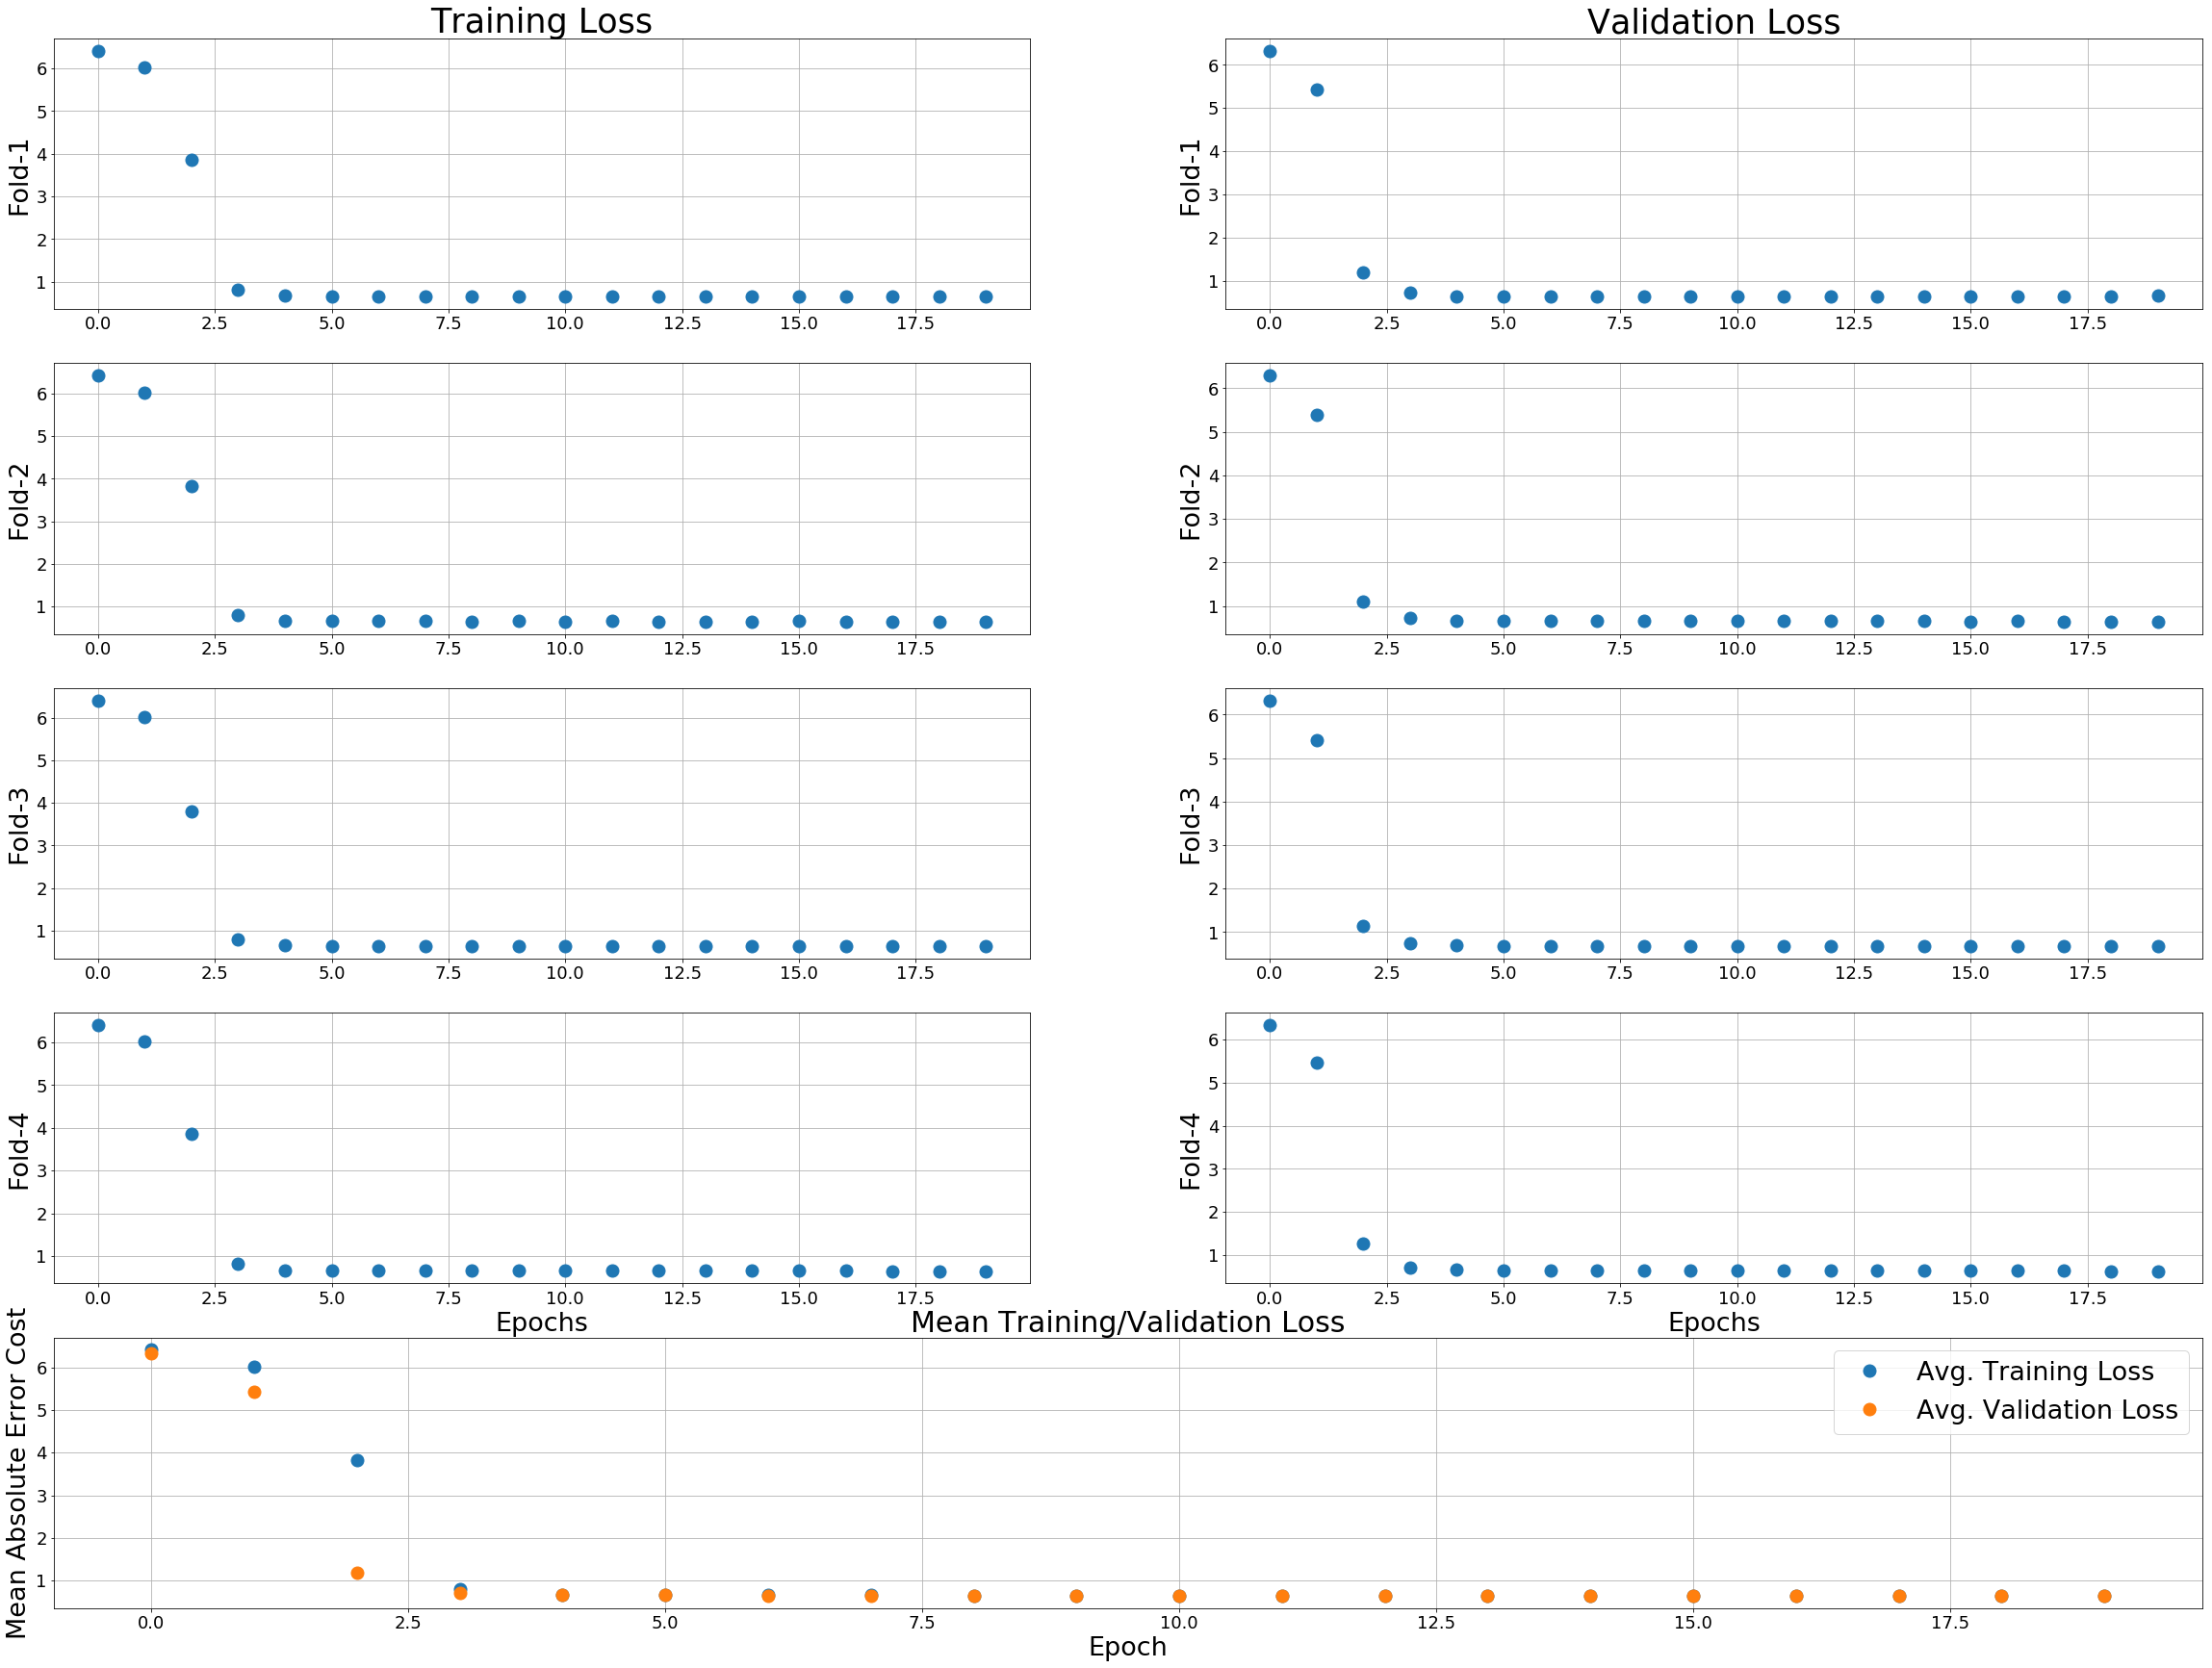

In [14]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

### This Is Good News!

This is great! It seems that the validation loss and training loss are at a pass and stay constant after about 10 epochs of stochastic gradient descent. Since we decided to use the mean absolute error cost function, it is easy to see that after 10 epochs of training we our average error across when using budgets to predict ratings is off by $\approx \pm 0.6$. This error rate is on a scale with ratings that range between 0 and 10.

One very useful metric to determine is which set of weights for our network were the "most useful." One way to determine this is to sort the validation and training losses  in lexicographical order.

Luckily, the NumPy library provides a function, lexsort(), that does lexicographical sorting and returns the indices of the order for the elements. In other words, we sort our loss data, first by order from smallest to largest validation loss, and then from smallest to largest training loss.

In [15]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[18 15 17 10 19 12 11 16  9 14  8 13  7  6  5  4  3  2  1  0]

Therefore, Epoch:18 would be a good place to stop training this model.


# REPEAT NOW: Create Rating Regression Model Based Only Top 3 Paid Cast Members

In [16]:
X = createFeatures('cast')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [17]:
num_epochs = 50

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=0, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

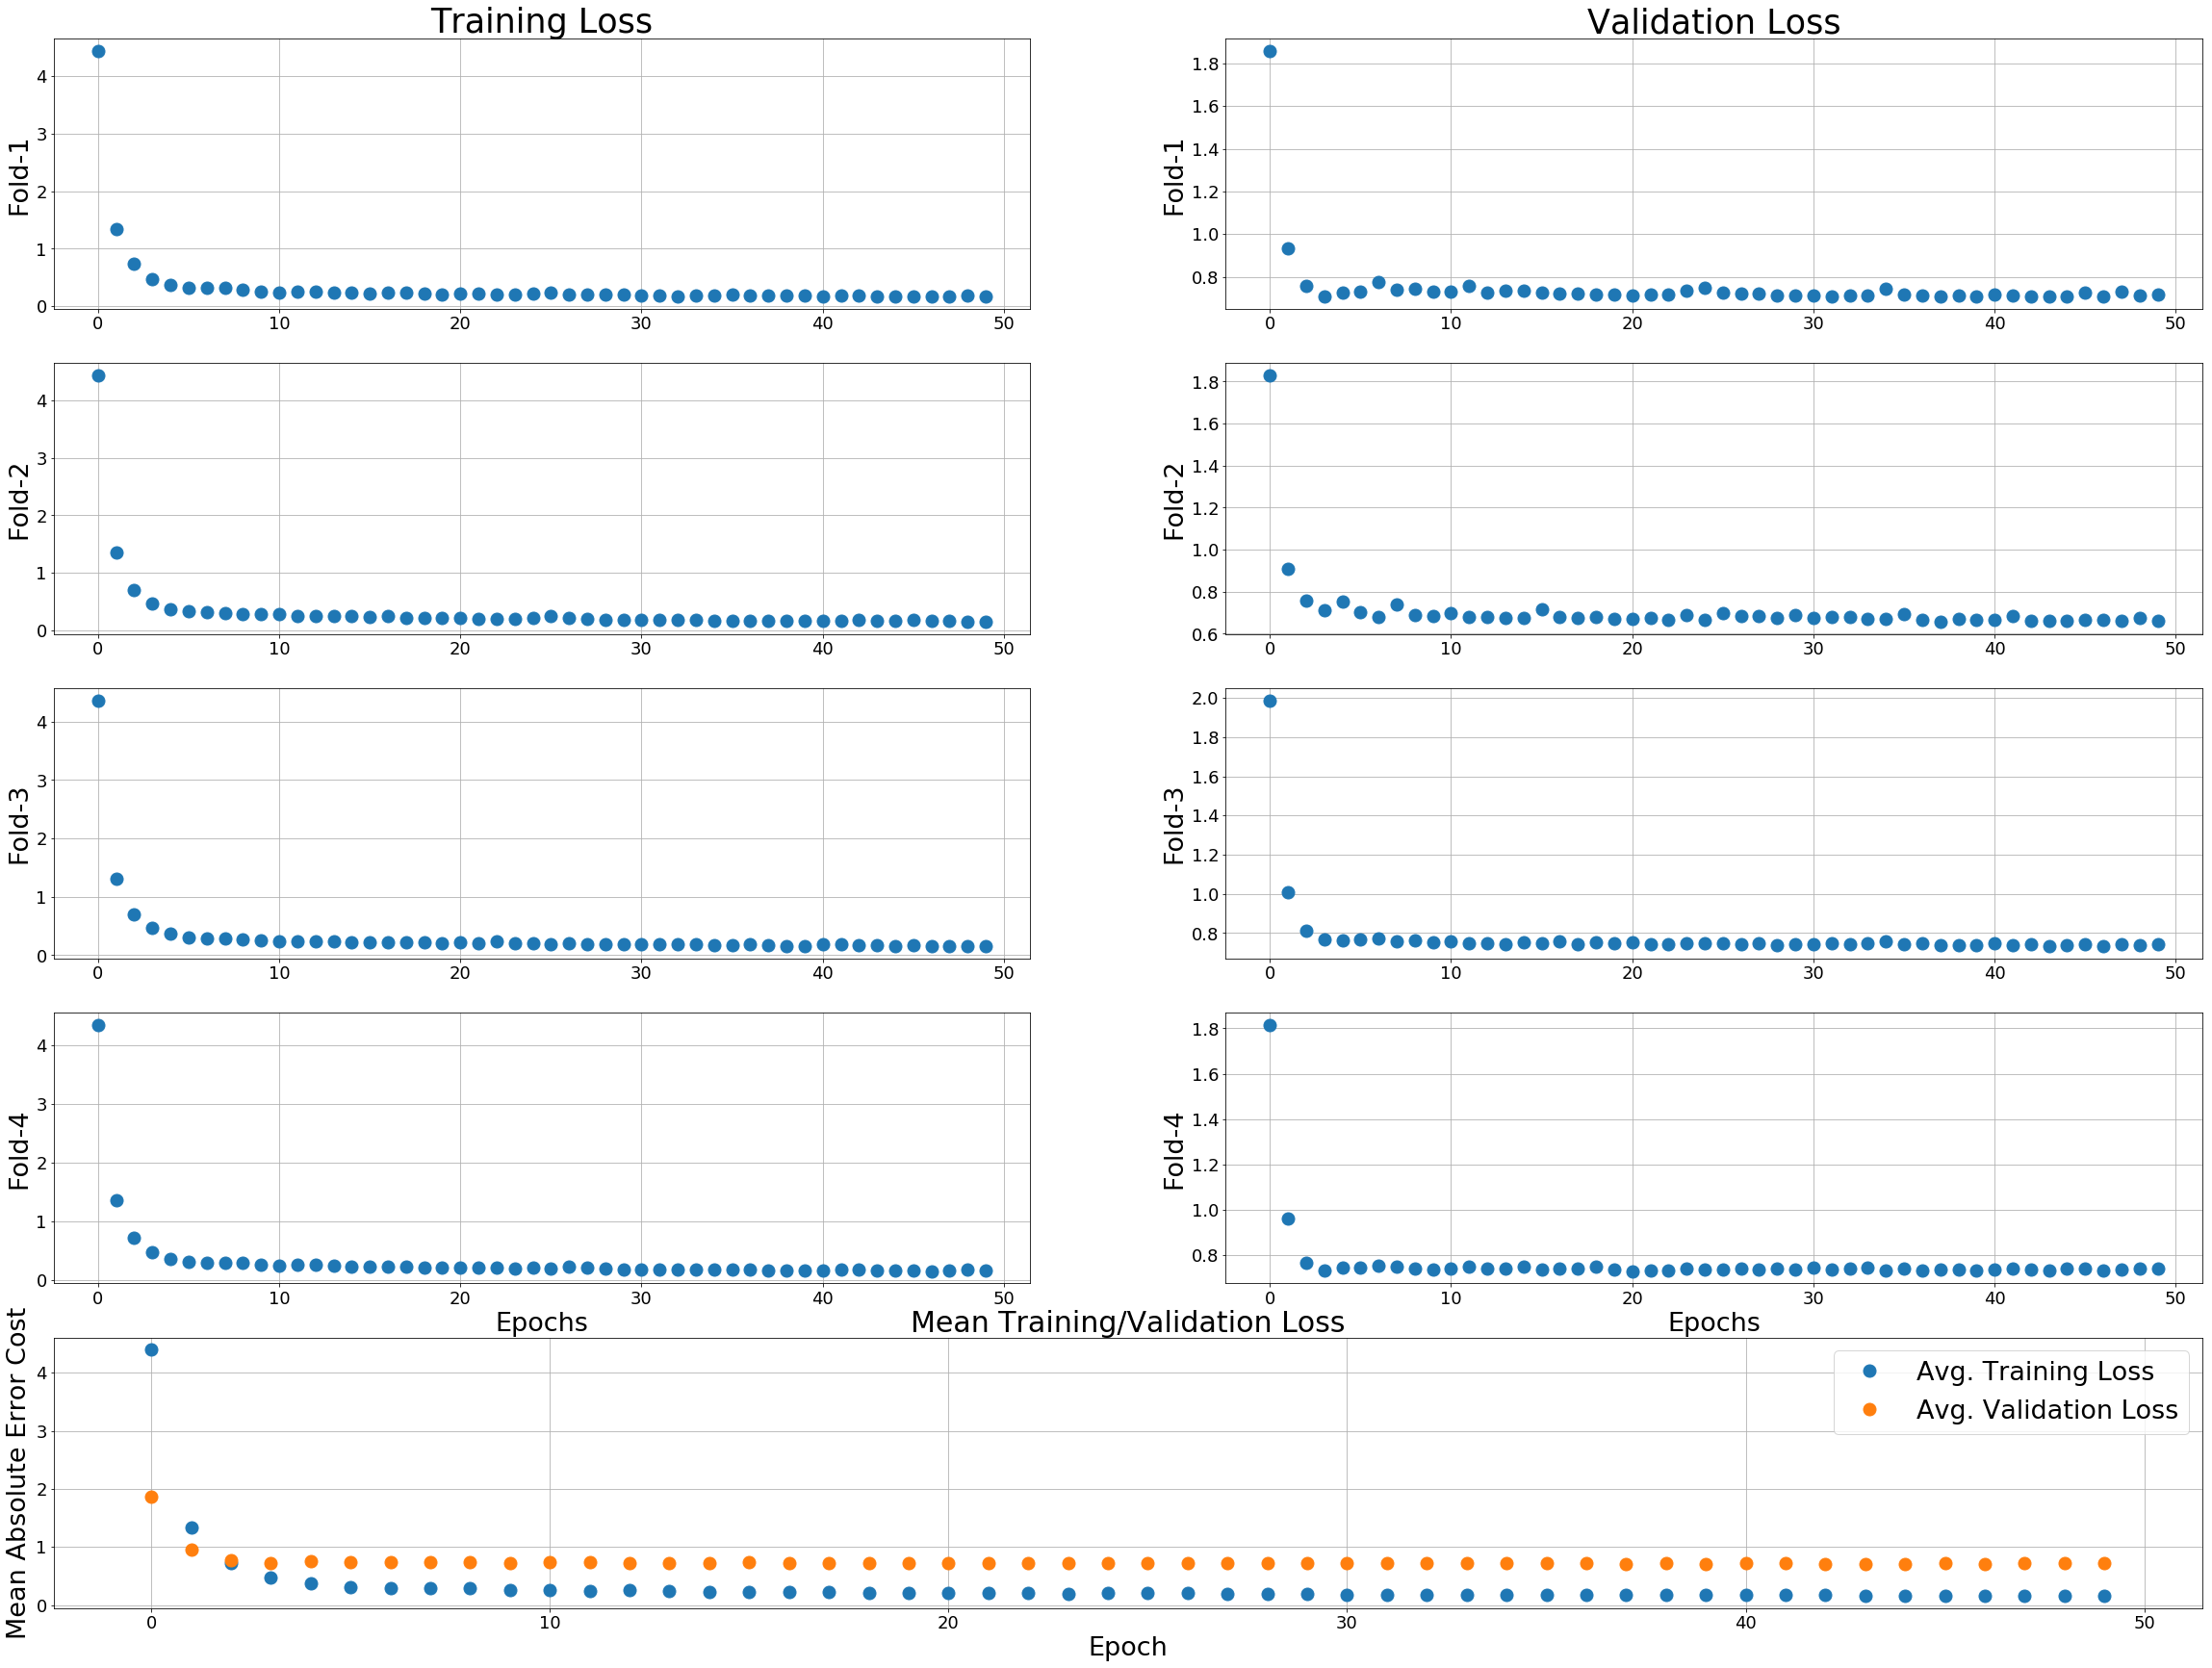

In [18]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [19]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[43 37 46 39 44 42 38 22 36 49 21 20 48 28 40 47 45 31 19 32 41 30 33 17 29
 26 35 27 12 18 16 13 24  9 25 34 14 23  3 10 15  8 11  5  6  7  4  2  1  0]

Therefore, Epoch:43 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our cast members per movie. In other words, we create 1 movie for every actor/actress in our "distinctCast" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [20]:
Xset = []
for i in range(0, len(distinctCast)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for castMember in Xset:
    predictions.append(float(model.predict(castMember)))

idx = np.argsort(predictions)

In [21]:
dList = list(distinctCast)

print('The best choices to make if you were to a cast only one "top-3" cast member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top-3" cast member would be:

Brad Pitt
Denzel Washington
Tom Hanks
Vin Diesel
Leonardo DiCaprio
Joe Pesci
Robert De Niro
Elijah Wood
Ralph Fiennes
Clint Eastwood
Joaquin Phoenix
Kristen Wiig
Ed Harris
Robert Redford
Jared Leto
Alec Baldwin
Michael Caine
Bruce Willis
Marlon Brando


Given the state of the film industry today, the names that this model was able extrapolate are of various actors/actresses who have appeared in a lot of critically and commercially successful films, such as Brad Pitt, Tom Hanks, Leonardo Dicaprio, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Director & Producer

In [22]:
X = createFeatures('crew')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [23]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=0, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

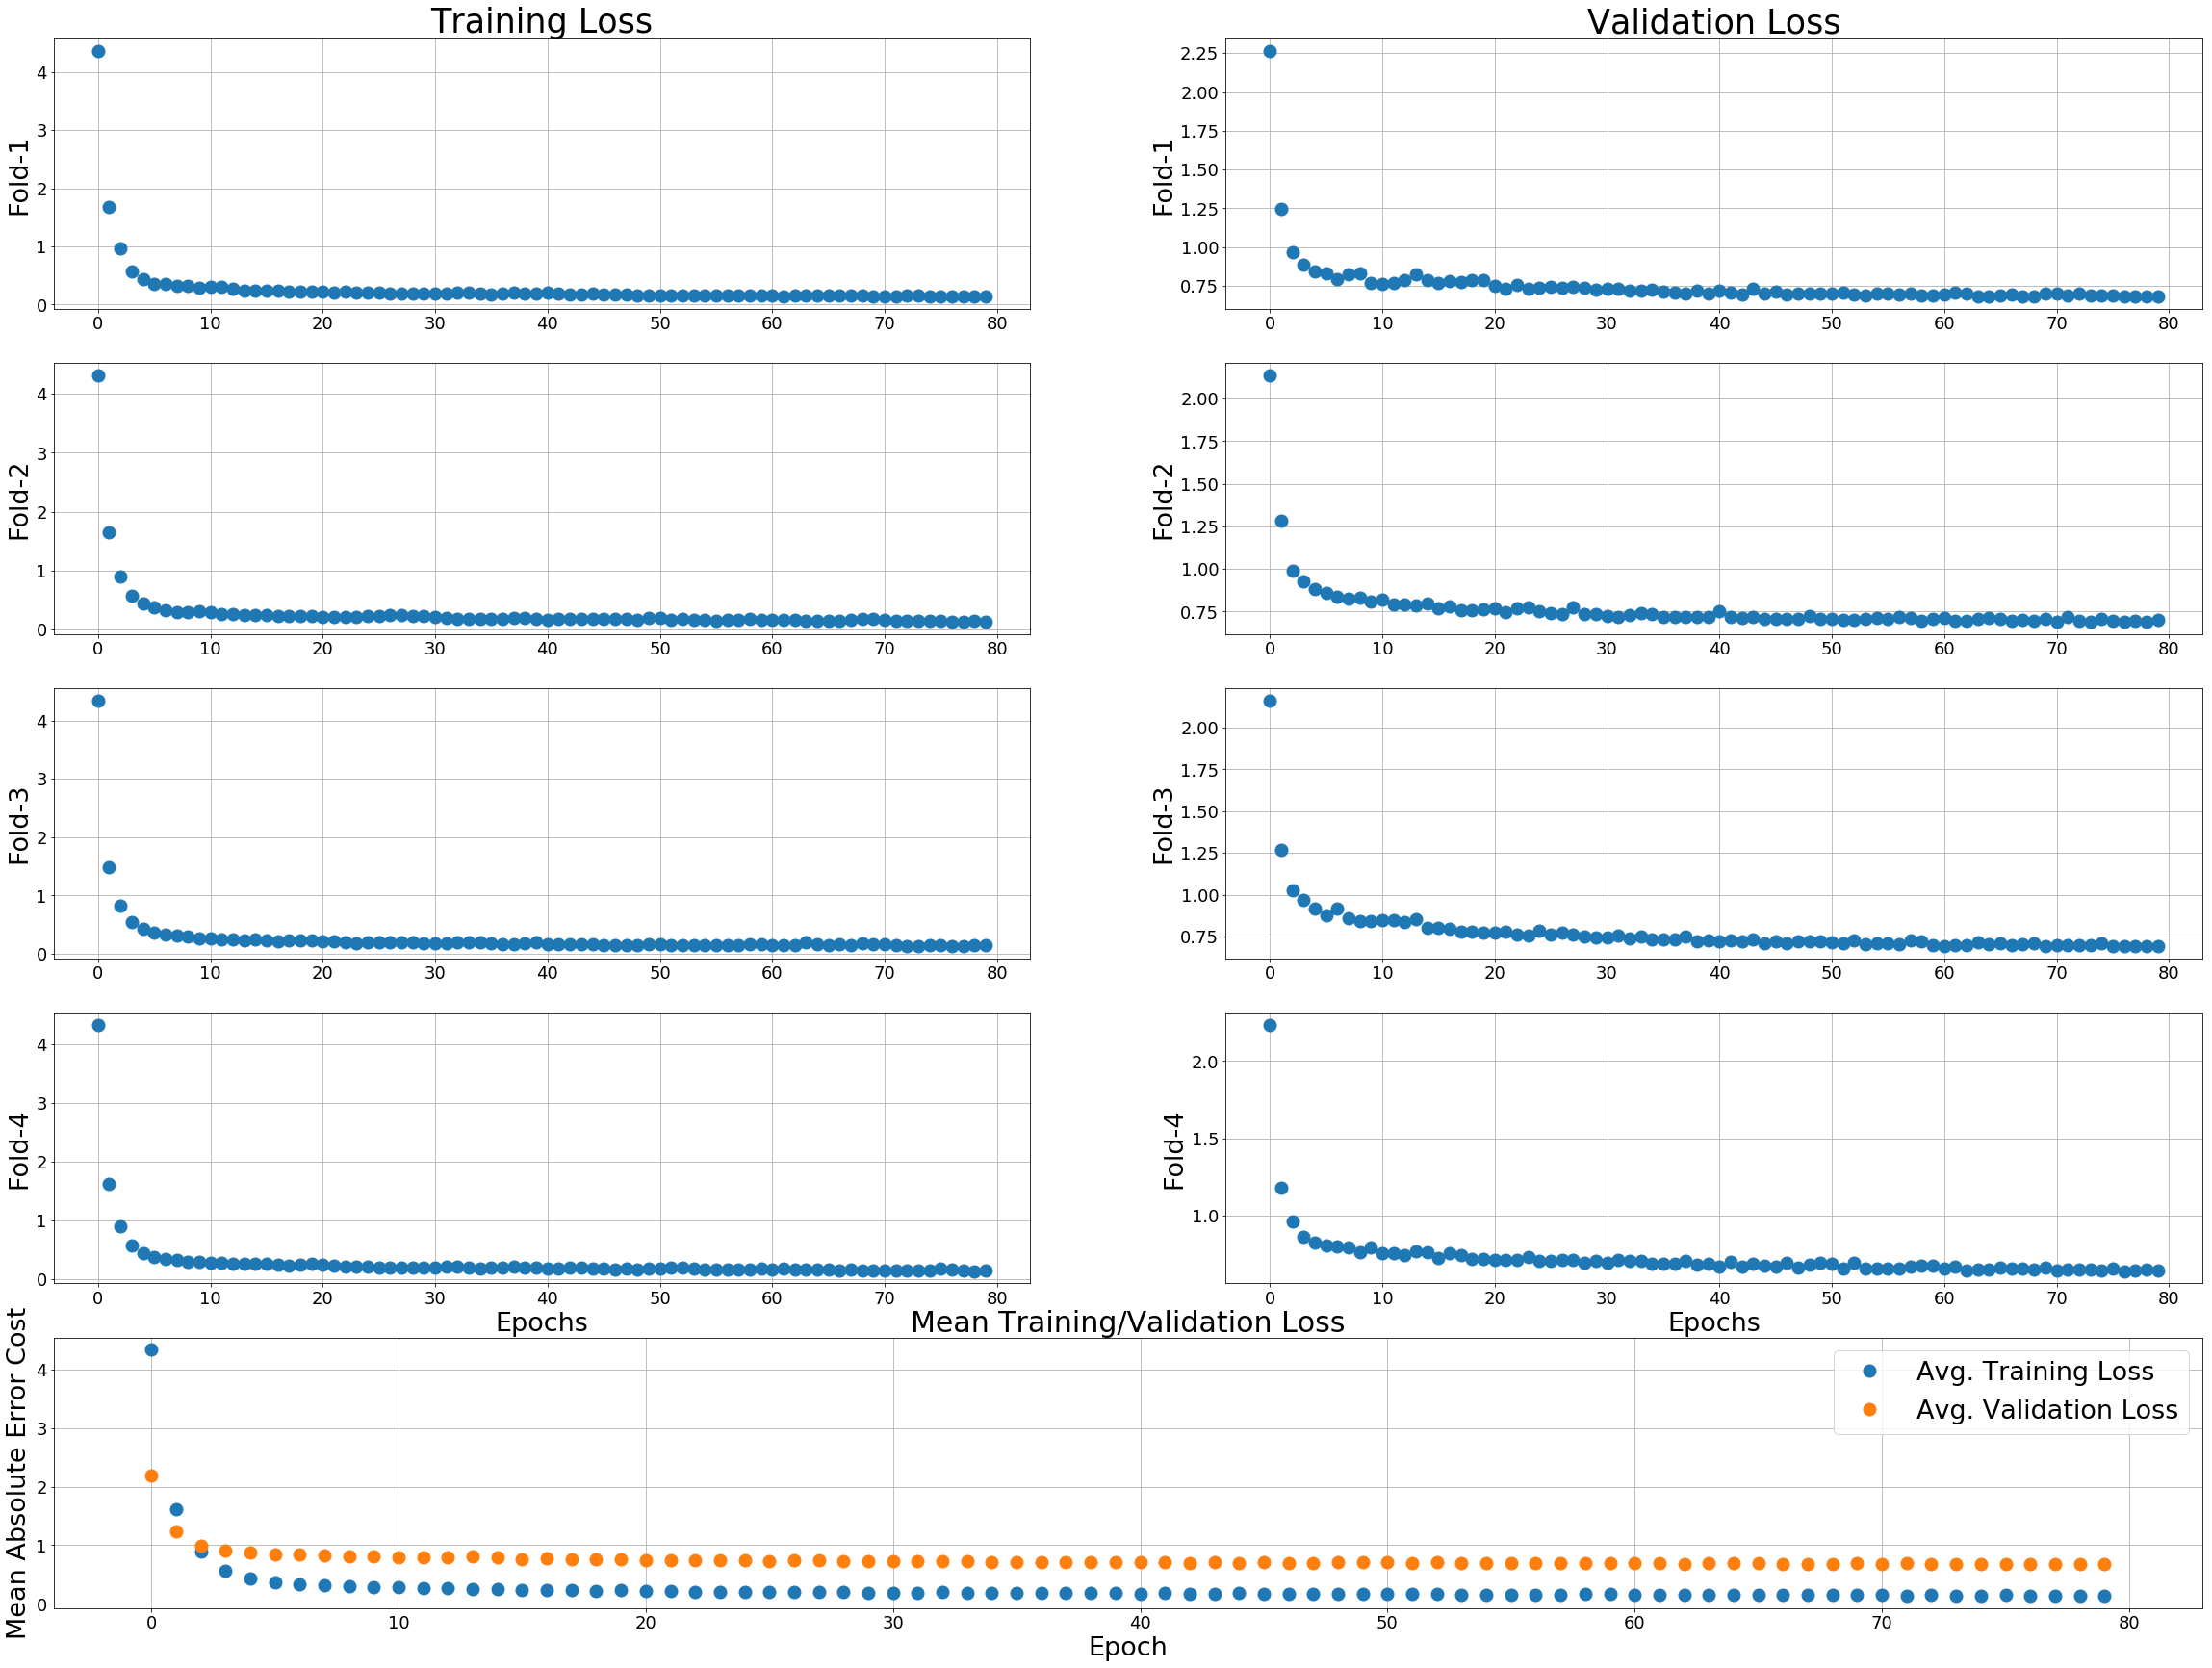

In [24]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [25]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[76 77 79 78 73 70 75 68 67 72 74 66 62 64 71 63 60 53 69 65 55 61 59 51 56
 54 58 47 44 42 57 46 52 45 50 49 48 39 38 36 41 35 40 43 34 37 30 32 33 28
 29 31 25 26 21 24 27 23 20 22 18 19 17 15 16 14 12 11 10  9 13  8  7  6  5
  4  3  2  1  0]

Therefore, Epoch:76 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our crew members per movie. In other words, we create 1 movie for every director/producer in our "distinctCrew" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [26]:
Xset = []
for i in range(0, len(distinctCrew)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for crewMember in Xset:
    predictions.append(float(model.predict(crewMember)))

idx = np.argsort(predictions)

In [27]:
dList = list(distinctCrew)

print('The best choices to make if you were to a cast only one "top" crew member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" crew member would be:

Stanley Kubrick
Martin Scorsese
James Cameron
Christopher Nolan
Sergio Leone
Lasse Hallstr\u00f6m
Frank Darabont
James Mangold
Steven Spielberg
Joe Wright
David Heyman
Barry Mendel
Kevin Feige
David Lynch
Frank Capra
Alfred Hitchcock
Lorne Orleans
Gary Barber
Albert S. Ruddy


Given the state of the film industry today, the names that this model was able extrapolate are of various directors/producers who have worked on a lot of critically and commercially successful films, such as Stanley Kubrick, Martin Scorsese, James Cameron, Christopher Nolan, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Genres

In [28]:
X = createFeatures('genres')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [29]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=0, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

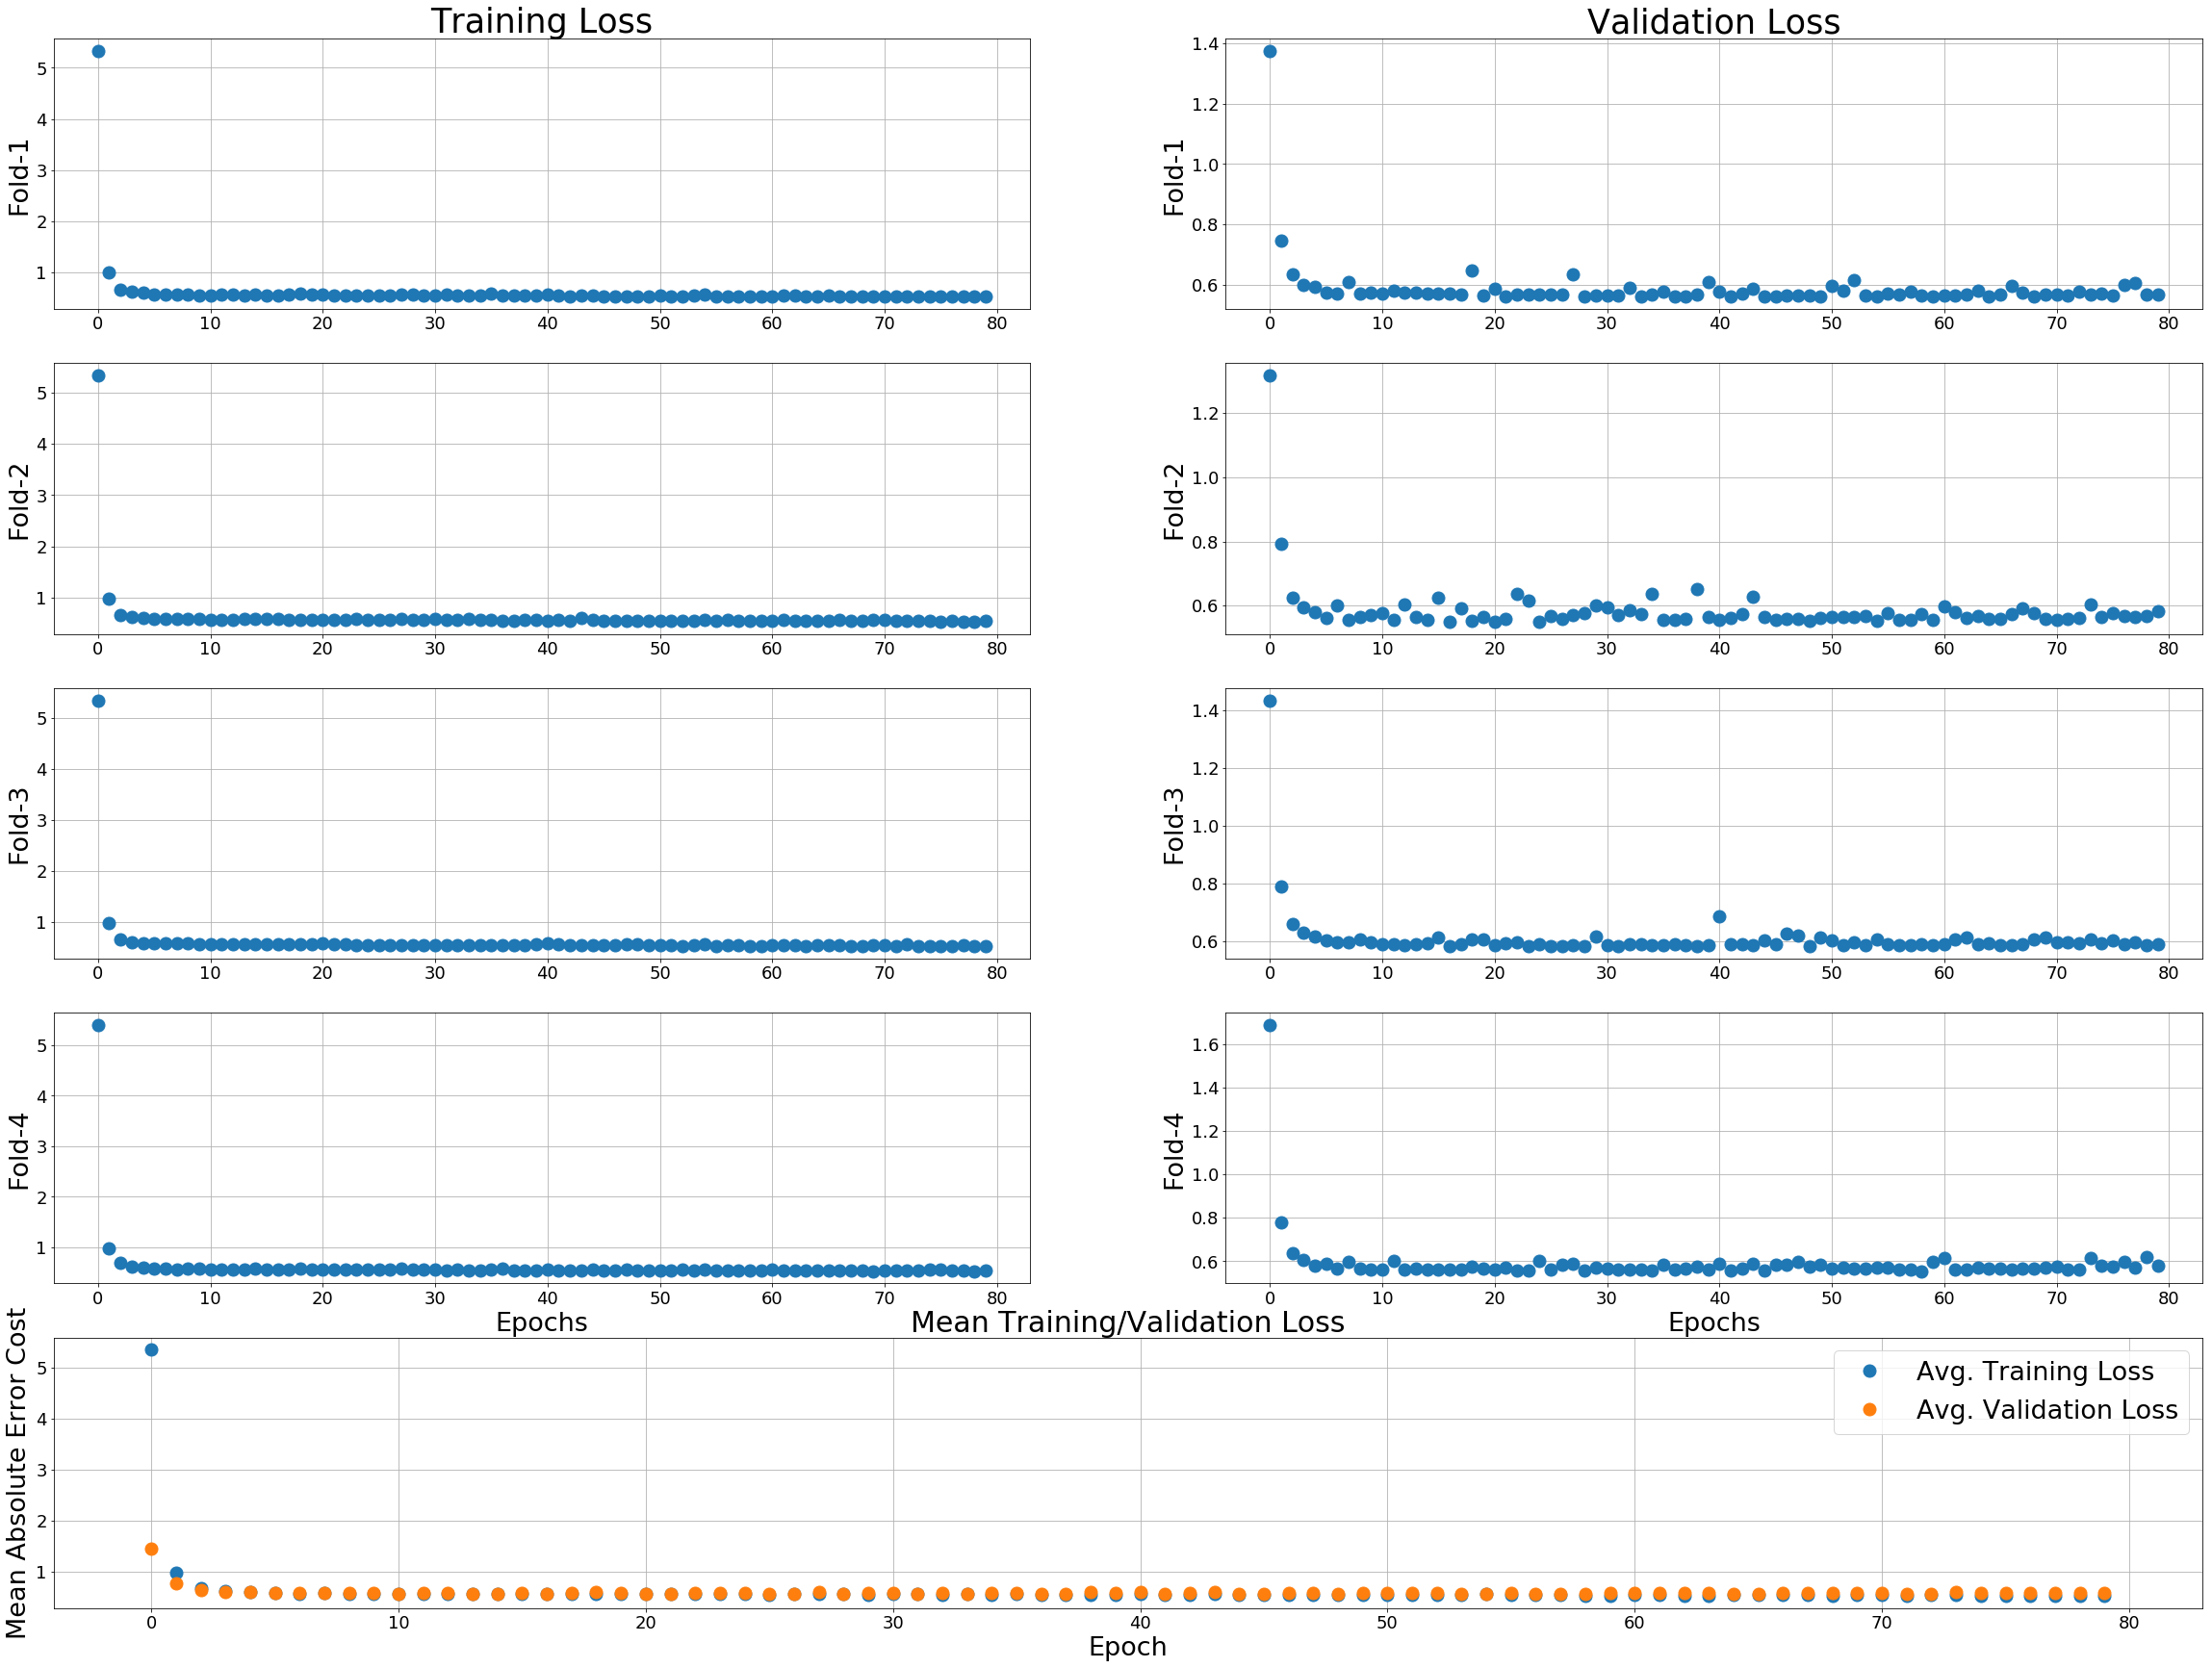

In [30]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [31]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[56 36 41 16 48 37 64 28 65 14 31 25 21 58 71 53 33 57 20 44 72 45 54 26 13
 10 70 42  9 59 19 35 51 62 55 74 24  8 63 17 68 69 61 30 66 79 39 75 49 67
 23 50  5 11 12 32 46  6 77 52 47 78 34 29 76 22  7 60 15  4 38 27 18 43 73
 40  3  2  1  0]

Therefore, Epoch:56 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these genres per movie. In other words, we create 1 movie for every genre in our "distinctGenres" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [32]:
Xset = []
for i in range(0, len(distinctGenres)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for genre in Xset:
    predictions.append(float(model.predict(genre)))

idx = np.argsort(predictions)

In [33]:
dList = list(distinctGenres)

print('The best choices to make if you were to a cast only one top genre would be:\n')
for i in idx[-1:20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one top genre would be:



Given the state of the film industry today, the order of genres that this model was able extrapolate corresponds to the critical and commercial success of our times today. Star Wars for example, contains the top 4 genres and can fit under the genres of:
- Mystery
- Romance
- Animation
- War
- Drama
- Fantasy
- and more.

# REPEAT NOW: Create Rating Regression Model Based Only On Production Companies

In [34]:
X = createFeatures('prod')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [35]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=0, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

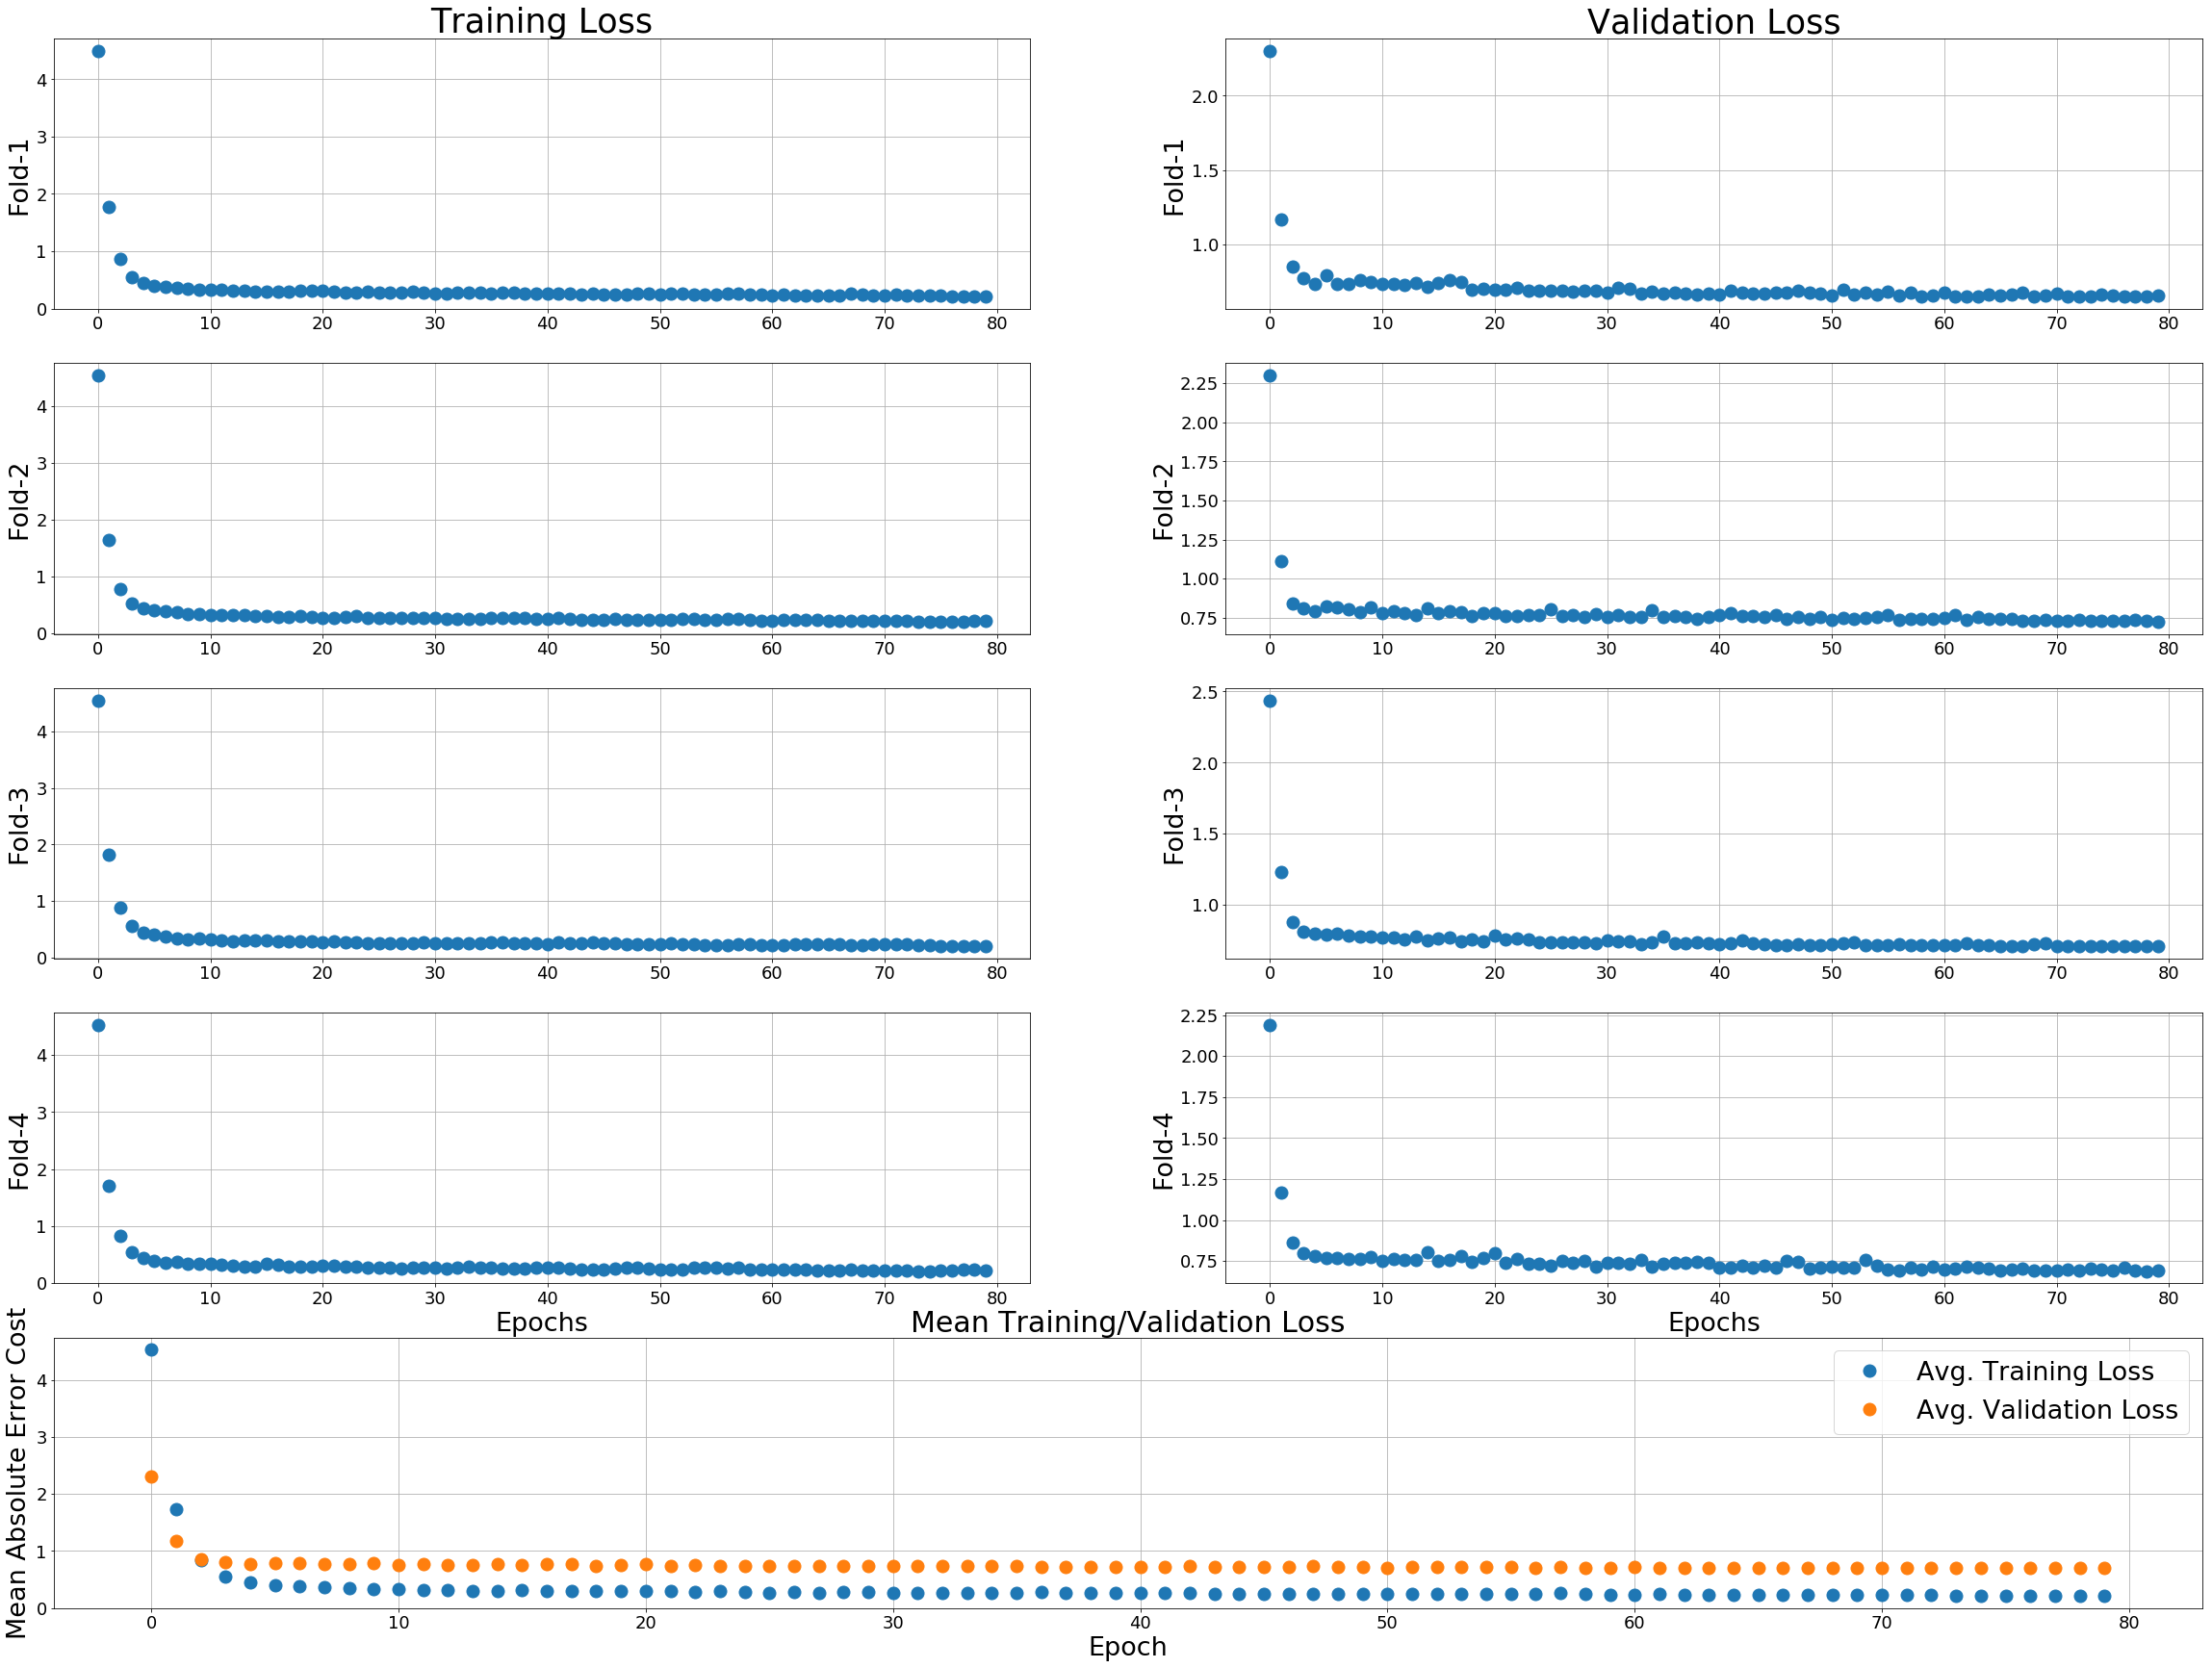

In [36]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [37]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[78 71 79 72 75 77 73 74 70 68 76 65 56 58 66 69 67 62 64 59 63 61 50 60 57
 48 49 54 55 52 44 45 40 43 51 46 37 38 39 53 41 36 29 47 30 42 33 27 24 34
 28 32 35 26 25 21 23 31 18 22 19 12 10 15 13 20 17 11 16  8  7 14  4  9  6
  5  3  2  1  0]

Therefore, Epoch:78 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these production companies per movie. In other words, we create 1 movie for every production company in our "distinctProd" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [38]:
Xset = []
for i in range(0, len(distinctProd)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for prod in Xset:
    predictions.append(float(model.predict(prod)))

idx = np.argsort(predictions)

In [39]:
dList = list(distinctProd)

print('The best choices to make if you were to a cast only one "top" production company would be:\n')
for i in idx[-1:20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" production company would be:

Warner Bros.
Syncopy
WingNut Films
Studio Ghibli
The Weinstein Company
United Artists
Twentieth Century Fox Film Corporation
Sunswept Entertainment
Winkler Films
Constantin Film Produktion
Pixar Animation Studios
Toho Company
Cloud Eight Films
Paramount Vantage
Lucasfilm
Castle Rock Entertainment
TriStar Pictures
Warner Bros. Animation
U-Drive Productions
Scion Films
Mr. Mudd Production
Temple Hill Entertainment
Barry Mendel Productions
Heyday Films
40 Acres & A Mule Filmworks
Blue Sky Studios
One Race Productions
Blue Parrot Productions
American Zoetrope
Jersey Films
Studio Canal
American Empirical Pictures
Miramax Films
Riche-Ludwig Productions
Walt Disney Feature Animation
Kurtzman/Orci
Wigram Productions
Horizon Pictures (II)
Groucho II Film Partnership
Ingenious Media
Selznick International Pictures
Reiner / Greisman Productions
Alfran Productions
Jinks/Cohen Company
Epsilon Motion Pictures

Big Arty Productions
Televisi\u00f3 de Catalunya TV3
Scott Rudin Productions
Cruel Productions
Motion Picture BETA Produktionsgesellschaft
Stoller Global Solutions
EDI
Langley Productions
Signal Film Group
RatPac Entertainment
Bungalow 78 Productions
Entertainment Films
NEW Century
Twins Financing
Film Capital Europe Funds (FCEF )
Lorimar Film Entertainment
Clarius Entertainment
Sid & Marty Krofft Pictures
A113
Subterranean Productions UK Ltd.
Revolt Films
CiBy 2000
Off Hollywood Pictures
Mars Films
Internationale Filmproduktion Prometheus
World Film Magic
Old Bull Pictures
Arc Productions
Indelible Productions
Anchor Bay Films
Alcor Films
Centre National de la Cin\u00e9matographie
Will Vinton Studios
Immortal Entertainment
Pontchartrain Productions
Sofica Sofinergie 5
Solomon/Hackett Productions
Tohokushinsha Film
Thunder Road Productions
Claudie Ossard Productions
Langley Park Production
Fear and Loathing LLC
Horseshoe Bay Productions
Polski Instytut Sztuki Filmowej
Origen Produccion

Green Room Films
Huckabee's
Furst Films
Happinet Pictures
Constant c Productions
Crystal Sky Pictures
October Films
Caravan Pictures
Path\u00e9
Angry Films
DW Studios
Todd McFarlane Entertainment
Grand Army Entertainment
Dead Crow Productions
Filmf\u00f6rderungsanstalt (FFA)
Wayfare Entertainment
Misher Films
Ten Thirteen Productions
Taken 3
Alta Loma Entertainment
Littlestar
Fat Free
Eric's Boy
Marvel Enterprises
Dragonfly Entertainment
JD Prod
20th Century Fox Russia
Max Stronghold Productions Inc.
Nomadic Pictures
Square USA
Lion Rock Productions
Egmond Film & Television
Cooper's Town Productions
Rye Road Productions
The Halcyon Company
Daybreak
Dovemead Films
Sil-Metropole Organisation Ltd.
JC 23 Entertainment
Envision Entertainment
Affirm Films
Rat Entertainment
WV Films III
Spitfire Pictures
Stan Winston Studio
Str8jacket Creations
Cinergi Pictures Entertainment
Sean S. Cunningham Films
Punch Productions
Arte France Cin\u00e9ma
Chambara Pictures
Black & White Productions
Kaplan/P

Given the state of the film industry today, the order of production companies that this model was able extrapolate corresponds to the critical and commercial success of our times today. For example, names such as:
- Warner Bros
- Syncopy
- WingNut Films
- United Artists
- The Weinstein COmpany
- Twentieth Century Fox
- and more.

# Last And Final Interesting Thing to Attempt: 
## Create Model That Uses All of These Modalities

Time to try to add layers for each of these modalities into one combined network.

In [40]:
# create arrays for seperate modalities
Xb = createFeatures('budget')
Xca = createFeatures('cast')
Xcr = createFeatures('crew')
Xg = createFeatures('genres')
Xp = createFeatures('prod')

# normalize each modality respectively
Xb_norm = normalize(Xb, axis = 0, norm = 'l2')
Xca_norm = normalize(Xca, axis = 0, norm = 'l2')
Xcr_norm = normalize(Xcr, axis = 0, norm = 'l2')
Xg_norm = normalize(Xg, axis = 0, norm = 'l2')
Xp_norm = normalize(Xp, axis = 0, norm = 'l2')

In [41]:
num_epochs = 80
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    
    # budget branch
    budgetInput = Input(shape = (Xb.shape[1],))
    budgetBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(budgetInput)
    budgetBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(budgetBranch)
    budgetBranch = BatchNormalization()(budgetBranch)
    
    # cast branch
    castInput = Input(shape = (Xca.shape[1],))
    castBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(castInput)
    castBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(castBranch)
    castBranch = BatchNormalization()(castBranch)
    
    # crew branch
    crewInput = Input(shape = (Xcr.shape[1],))
    crewBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(crewInput)
    crewBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(crewBranch)
    crewBranch = BatchNormalization()(crewBranch)
    
    # genre branch
    genreInput = Input(shape = (Xg.shape[1],))
    genreBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(genreInput)
    genreBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(genreBranch)
    genreBranch = BatchNormalization()(genreBranch)
    
    # production branch
    prodInput = Input(shape = (Xp.shape[1],))
    prodBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(prodInput)
    prodBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(prodBranch)
    prodBranch = BatchNormalization()(prodBranch)
    
    # added combine all the layers into one added network by adding an "add-layer"
    added = add([budgetBranch, castBranch, crewBranch, genreBranch, prodBranch])
    out = Dense(units = 1, kernel_initializer = initialWeights, activation='relu')(added)
    
    model = keras.models.Model(inputs = [budgetInput, castInput, crewInput, genreInput, prodInput], outputs = out)
    model.compile(loss='mean_absolute_error',optimizer = 'adam')
    
    history = LossHistory()
    model.fit(
        [Xb_norm[train], Xca_norm[train], Xcr_norm[train], Xg_norm[train], Xp_norm[train]], y[train],
        validation_data = ([Xb_norm[test], Xca_norm[test], Xcr_norm[test], Xg_norm[test], Xp_norm[test]], y[test]),
        epochs=num_epochs,
        batch_size=64,
        verbose=0,
        callbacks = [history]
    )
    
    cvScoresHistory.append(history.losses)

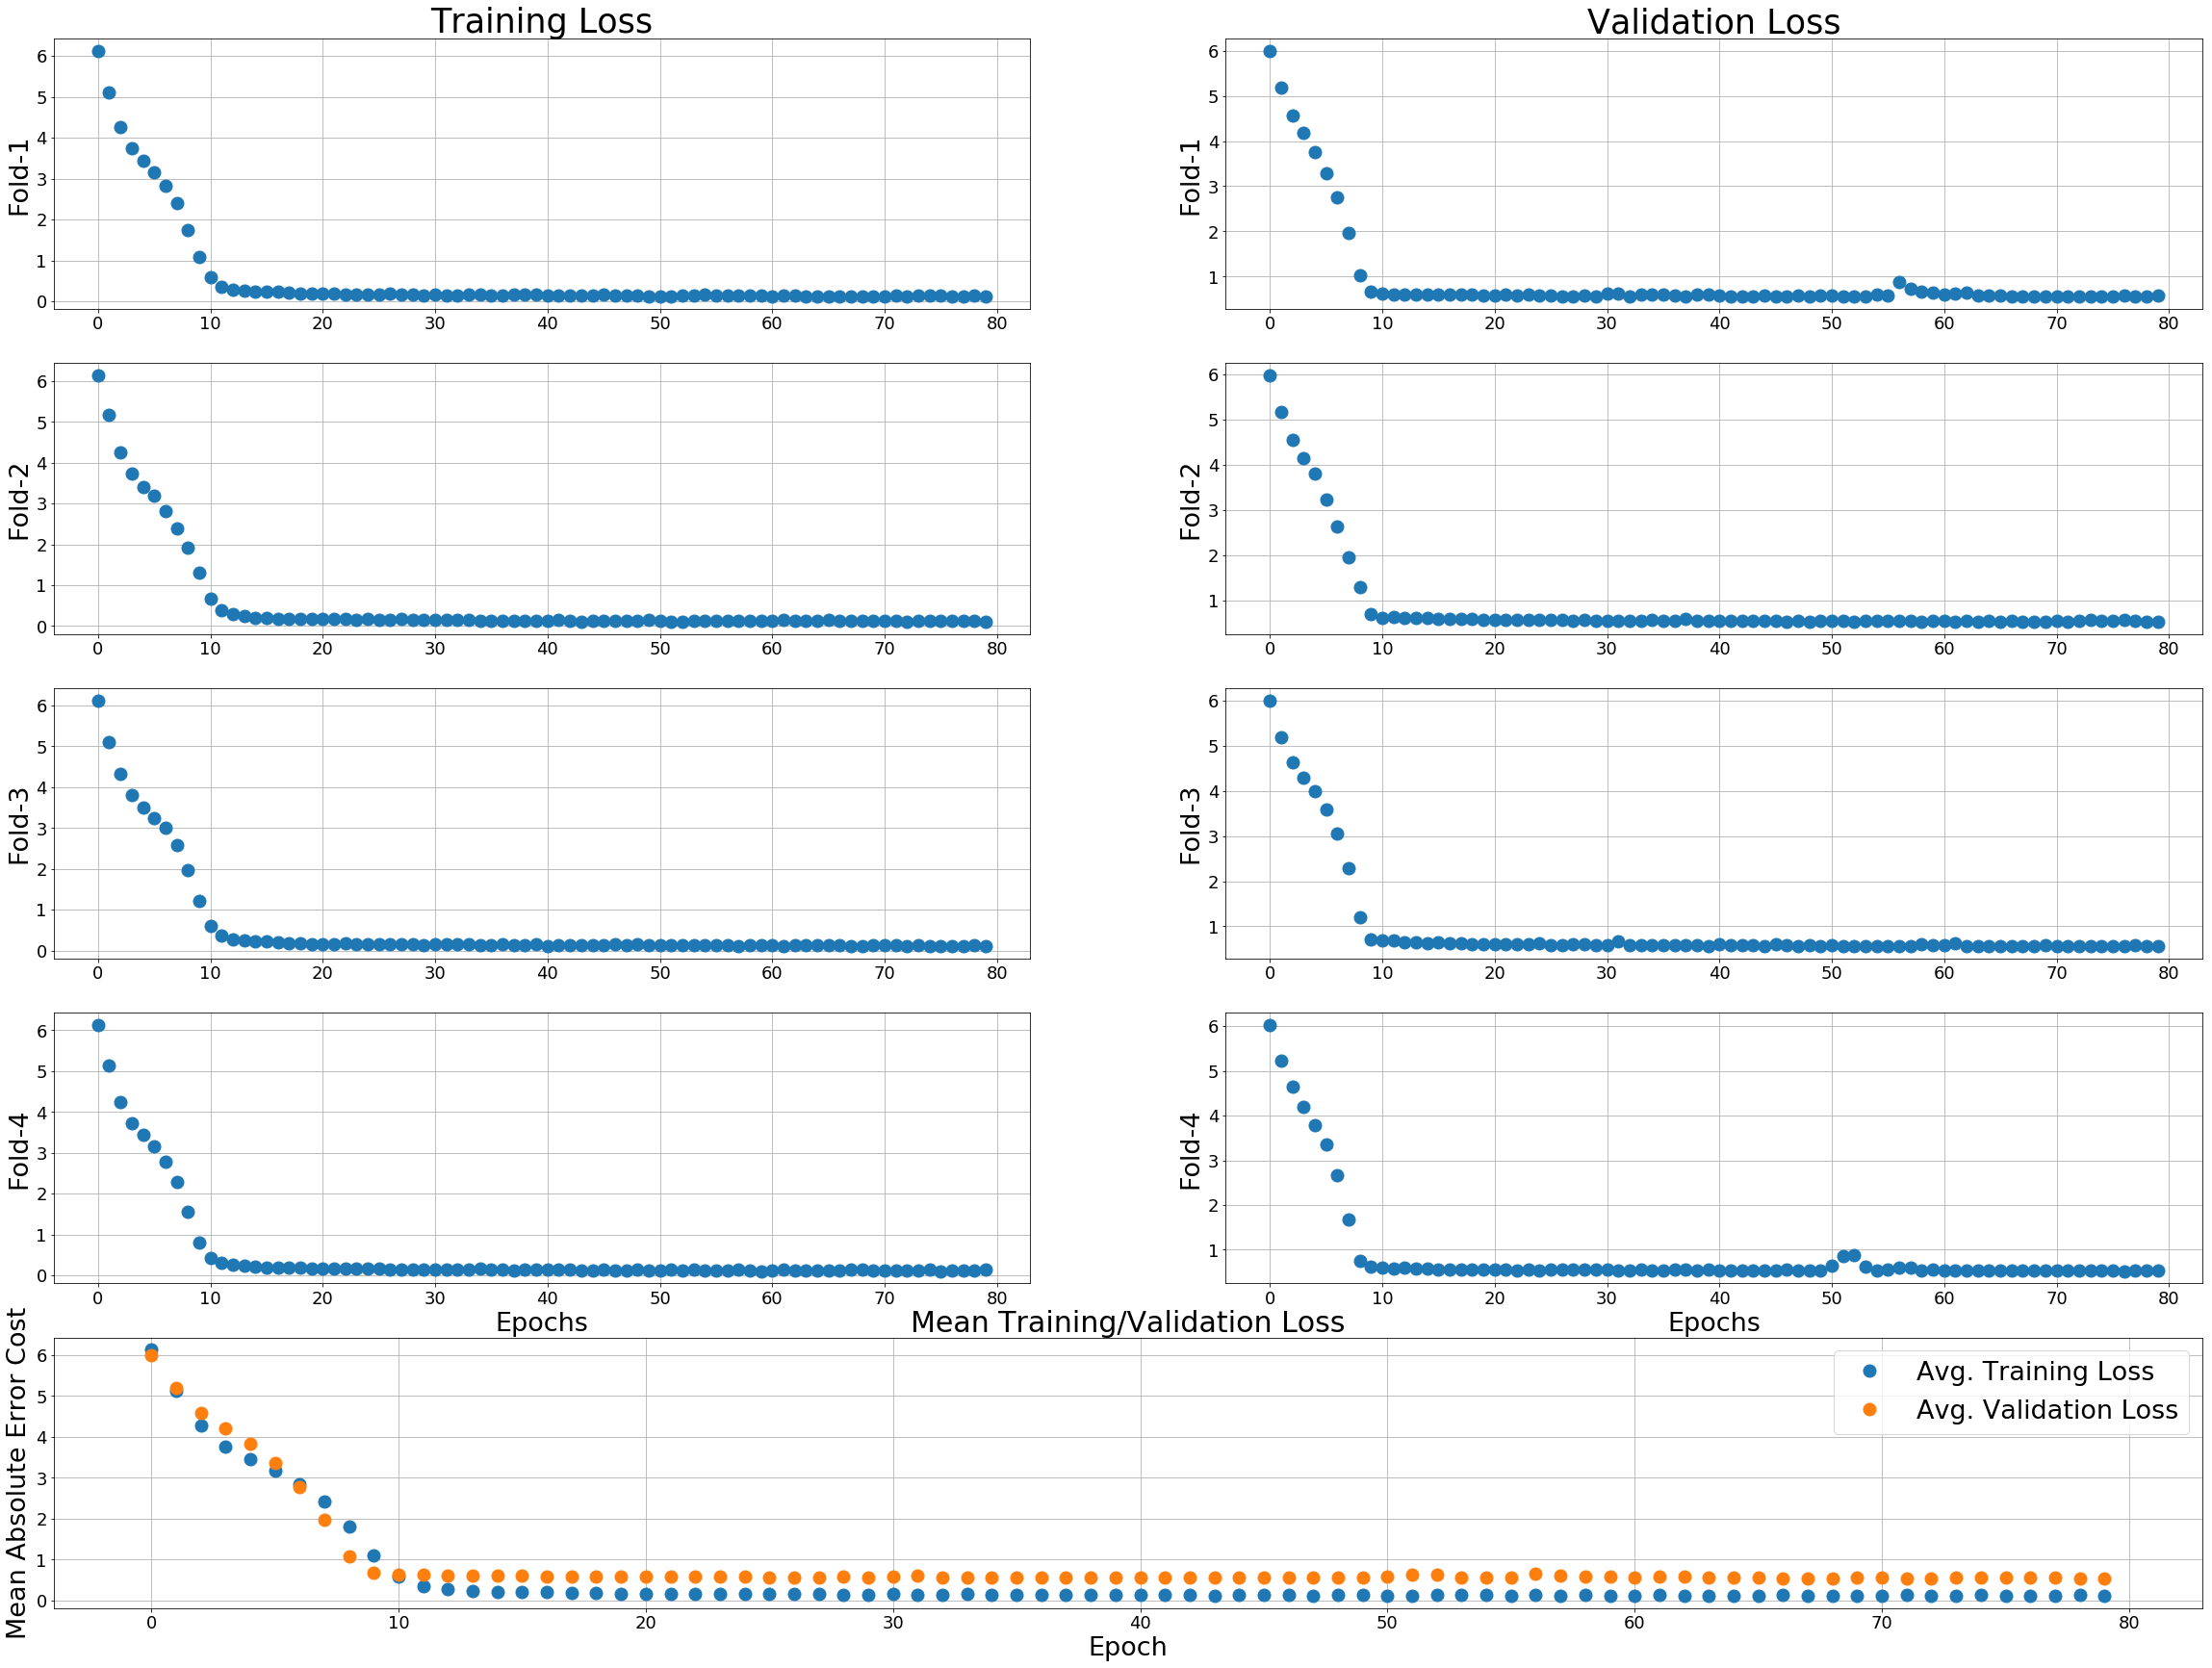

In [42]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [43]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[67 71 78 66 72 68 79 75 70 69 73 65 48 63 77 41 47 74 44 76 64 42 46 49 45
 54 55 43 32 40 36 60 38 29 26 35 39 37 33 27 34 25 53 24 28 62 22 20 19 30
 23 21 61 18 59 50 58 17 16 31 15 14 12 13 57 11 10 51 52 56  9  8  7  6  5
  4  3  2  1  0]

Therefore, Epoch:67 would be a good place to stop training this model.
